# lacY Properties
Calculate physiochemical and mutational properties of lacY

In [1]:
%load_ext autoreload
%autoreload 2
from scipy import stats
import pandas as pd
pd.set_option('display.max_rows', 1000)
import numpy as np
from pymol import cmd
import sys
import os
sys.path.insert(0, os.path.abspath('utilities'))
from distancetoatom_script import distancetoatom
import data2bfactor as dbf
from pairwisedistances import pairwise_dist
import custom_pymol_util as jpu
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

import plotly.express as px
from Bio.PDB import PDBParser
from Bio.PDB.DSSP import DSSP
import Bio
import Bio.SeqUtils
import Bio.codonalign
import Bio.KEGG.REST as BKR
#https://www.pymolwiki.org/index.php/Iterate
#https://pymolwiki.org/index.php/Selection_Algebraç


/opt/conda/lib/python3.7/site-packages/Bio/codonalign/__init__.py:26: BiopythonExperimentalWarning: Bio.codonalign is an experimental module which may undergo significant changes prior to its future official release.
  BiopythonExperimentalWarning,


# Load protein

In [2]:
cmd.delete('all')
cmd.fetch("1PV7")
atomDF = jpu.get_atom_from_selection('all')
protlen = 417

 PyMOL not running, entering library mode (experimental)


# Find distance of resi to sugar

In [3]:
#Selection
distance = 10
query = "chain A"
target = '/1PV7/C/E/GAL or /1PV7/C/E/YIO'
dist2sugar = jpu.find_dist(query, target, distance)
aa = dist2sugar
atomDF['dist2sugar'] = dist2sugar
resDF = atomDF[(atomDF['chain']=='A')].groupby(['resi']).min().loc[1:417]

100%|██████████| 6626/6626 [00:07<00:00, 848.13it/s] 


# Processing variants

In [4]:
# Get variants
allGeneVariants = pd.read_excel('../data/ec_variant_SS_rescuedlt5.xlsx', index_col=[0,1],header=0)
geneVariants = allGeneVariants.loc['lacY']
var_loc = geneVariants['aa_pos']

# Get effects of mutations
distance_matrix = pd.read_excel('../data/Miyata_distance.xlsx')
m = np.triu(np.array(distance_matrix.set_index('Unnamed: 20')))
i_lower = np.tril_indices(m.shape[0], -1)
m[i_lower] = m.T[i_lower]
np.fill_diagonal(m,0)
miyata_matrix = pd.DataFrame(m,index=distance_matrix['Unnamed: 20'].values,columns=distance_matrix['Unnamed: 20'].values)

mutation = geneVariants[['aa_pos','aa_before','aa_after']]
mutation['aa_pos'] = mutation['aa_pos'].astype('int')
impact = []
for ind,i in mutation.iterrows():
    try:
        impact.append(miyata_matrix.loc[i['aa_before'],i['aa_after']])
    except KeyError:
        impact.append(np.nan)
mutation['impact'] = impact
mutation_pos = mutation['aa_pos']
missense_mutation = mutation[mutation['impact']>0]
missense_count = missense_mutation['aa_pos'].count() #Count missense mutation

#variant location
length = len(resDF.loc[0:437].index)
variants = np.zeros(length)
variants[mutation_pos[mutation_pos<length]] = mutation[mutation_pos<length]['impact']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# dN/dS

In [5]:
# Get OG seq
window = 15
gene = 'LacY'
kegg_data = list(BKR.kegg_get(f'ect:LacY', option="ntseq"))
kegg_data2 = list(BKR.kegg_get(f'ect:LacY', option="aaseq"))
ntseq = "".join([i.rstrip() for i in kegg_data[1:]])
aaseq = "".join([i.rstrip() for i in kegg_data2[1:]])

# Get mutated seq
## Mutate sequence
mutseq = list(ntseq)
for i in geneVariants['nt_pos']:
    target = geneVariants.set_index('nt_pos').loc[i]['nt_aft']
    try:
        assert len(target)==1
    except AssertionError:
        target = target.iloc[0]
    mutseq[i-1] = target.lower()

mutseq = ''.join(mutseq)
window_dNdS = []
for pos in range(0, protlen):
    if (pos > window) & (pos < protlen-window-3):
        ntseq_window = ntseq[3*(pos-window):3*(pos+window)]
        mutseq_window = mutseq[3*(pos-window):3*(pos+window)]
        dN,dS = Bio.codonalign.codonseq.cal_dn_ds(Bio.codonalign.codonseq.CodonSeq(ntseq_window), Bio.codonalign.codonseq.CodonSeq(mutseq_window), method='NG86')
        try:
            window_dNdS.append(dN/dS)
        except ZeroDivisionError:
            window_dNdS.append(np.nan)
    else:
        window_dNdS.append(np.nan)

# Plot Figure

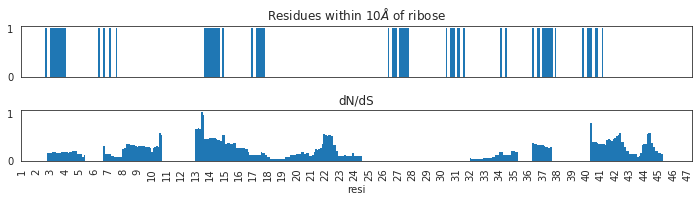

In [8]:
figure = plt.figure(figsize = (10,3))

# Plot distance from ribose
titles = r'Residues within 10$\AA$ of ribose'
dist2site = resDF['dist2sugar'].fillna(10)
dist2site[dist2site<10] = 1
dist2site[dist2site>=10] = 0
ax = figure.add_subplot(2,1,1)
pd.Series(dist2site).plot.bar(ax=ax, title=titles,width=1,edgecolor="none")
ax.axes.xaxis.set_visible(False)

# Plot dN/dS
ax = figure.add_subplot(212)
pd.Series(window_dNdS[0:protlen+1], resDF[0:protlen+1].index).plot.bar(ax=ax,title='dN/dS',width=1,edgecolor = "none")
#ax.set_ylim(0,0.5)

# Plot
figure.tight_layout()
plt.locator_params(axis='x',nbins=50)

#figure.savefig('../../results/LacY_distDNA_dNdS.pdf')

# p-value

In [11]:
site = dist2site==1
non_site = ~site
site_dNdS = pd.Series(window_dNdS[0:360],index=site.iloc[0:360].index)[site]
non_site_dNdS = pd.Series(window_dNdS[0:360],index=site.iloc[0:360].index)[non_site]
p_val = stats.ranksums(non_site_dNdS.dropna(), site_dNdS.dropna())
p_val

RanksumsResult(statistic=-2.183895686903561, pvalue=0.028969914033642137)